### 1. Imports

In [47]:
import csv  
import requests
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from scipy.sparse import csc_matrix, csr_matrix
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

In [2]:
train_hr = pd.read_csv('data/train_HR.csv')
train_lr = pd.read_csv('data/train_LR.csv')
test_lr = pd.read_csv('data/test_LR.csv')

print(train_lr.shape, train_hr.shape, test_lr.shape)

(189, 12720) (189, 35778) (90, 12720)


In [3]:
X = np.array(train_lr)
y = np.array(train_hr)

### 2. Utility Functions

In [4]:
def showLR(X, n):
    res = []
    last = 0
    for i in range(1,161):
        res.append(np.hstack((np.zeros(i), X[n][last:last+(160-i)])))
        last = last+(160-i)
    res = np.array(res)
    res = res.T + res
    return res

def showHR(y, n):
    res = []
    last = 0
    for i in range(1,269):
        res.append(np.hstack((np.zeros(i), y[n][last:last+(268-i)])))
        last = last+(268-i)
    res = np.array(res)
    res = res.T + res
    return res

def saveFigure(name, test_pred, errors):
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    fig.suptitle(name)

    ax[0].bar([1,2,3,4,5], errors)
    ax[0].set_title("5Fold Mean Squared Errors")
    
    ax[1].matshow(showHR(test_pred, 0))
    ax[1].set_title("Predicted HR Matrix from LR Sample #0")

    plt.savefig('figures/'+name+'.png')

def saveResults(filename, results):
    with open(filename, 'w', encoding='UTF8', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["ID", "predicted"])
        
        for i in range(results.size):
            writer.writerow([i, results[i]])

def calcScore(mse, redownload=False):

    if redownload:
        with open("leaderboard.zip",'wb') as out:
            r = requests.get("https://www.kaggle.com/competitions/36873/leaderboard/download/public")
            out.write(r.content)

        with zipfile.ZipFile("leaderboard.zip", 'r') as zip_ref:
            zip_ref.extractall("leaderboard")

    leaderboard = pd.read_csv("leaderboard/blg454e-spring-2022-term-project-publicleaderboard.csv")
    min_all = leaderboard["Score"].min()
    max_all = leaderboard["Score"].max()
    
    normalized_mse = (mse - min_all) / (max_all- min_all)
    print("Normalized MSE: ", normalized_mse)
    return normalized_mse

Text(0.5, 1.0, 'HR Sample')

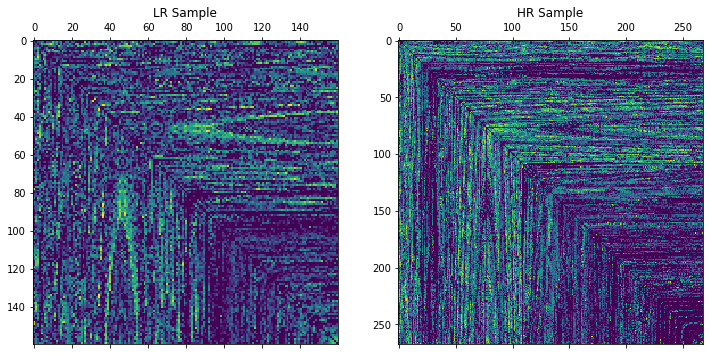

In [5]:
fig, ax = plt.subplots(1,2, figsize=(12,10))
ax[0].matshow(showLR(X, 0))
ax[0].set_title("LR Sample")
ax[1].matshow(showHR(y, 0))
ax[1].set_title("HR Sample")

### 3. PCA

In [50]:
ipca = PCA(n_components=189)
X_ipca = ipca.fit_transform(X)
x_test = ipca.transform(np.array(test_lr))

print(X_ipca.shape, x_test.shape)

(189, 189) (90, 189)


### 4. Model Training

In [60]:
def trainModel(regressor):
    # X_ipca = csc_matrix(X_ipca, dtype=np.float32)
    # x_test = csr_matrix(x_test, dtype=np.float32)

    kf = KFold(n_splits=5, shuffle=False)
    saved_model = None
    errors = []

    for train_index, test_index in kf.split(X_ipca):
        X_train, X_test = X_ipca[train_index], X_ipca[test_index]
        y_train, y_test = y[train_index], y[test_index]

        mlp = MultiOutputRegressor(regressor, n_jobs=-1)
        mlp.fit(X_train, y_train)

        test_pred = mlp.predict(X_test)
        err = mean_squared_error(y_test, test_pred)

        errors.append(err)
        print(err)
        if err <= min(errors):
            saved_model = mlp
    
    return saved_model, errors


In [64]:
saved_model, errors = trainModel(KNeighborsRegressor())

test_pred = saved_model.predict(x_test)
test_pred.shape

0.028612453211429835
0.03153066246740618
0.028018848543530688
0.02973119152746092
0.029851895436237494


(90, 35778)

### 5. Results

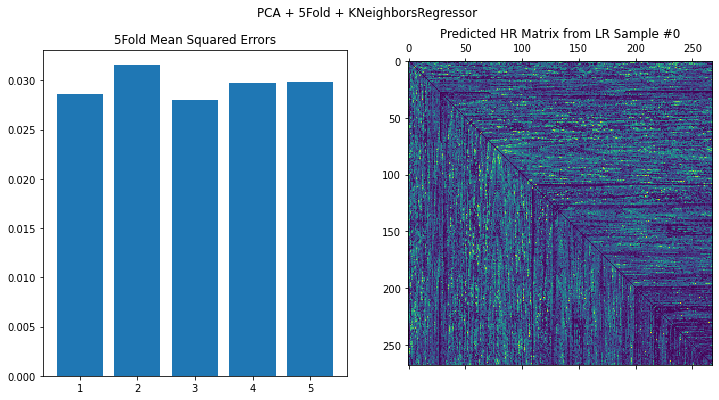

In [65]:
saveFigure('PCA + 5Fold + KNeighborsRegressor', test_pred, errors)

In [63]:
saveResults('outputs/PCA_5fold_KNeighborsRegressor.csv', test_pred.flatten())

### ------------------------------------

In [75]:
X, y = make_regression(n_features=1000, n_informative=2, random_state=0, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [80]:
reg = RandomForestRegressor(max_depth=100, random_state=0)
reg.fit(X_train, y_train)
print("Score: ", cross_val_score(reg, X_train, y_train, cv=5).mean())

mean_squared_error(y_test, reg.predict(X_test))

Score:  0.6392239474406961


1187.6061630628055

In [77]:
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)
print("Score: ", cross_val_score(reg, X_train, y_train, cv=5).mean())

mean_squared_error(y_test, reg.predict(X_test))

Score:  0.7170330604115447


1719.7369060464055

In [78]:
reg = DecisionTreeRegressor(random_state=0)
reg.fit(X_train, y_train)
print("Score: ", cross_val_score(reg, X_train, y_train, cv=5).mean())

mean_squared_error(y_test, reg.predict(X_test))

Score:  0.378581708851575


4920.578040461663

In [79]:
reg = AdaBoostRegressor(n_estimators=100, random_state=0)
reg.fit(X_train, y_train)
print("Score: ", cross_val_score(reg, X_train, y_train, cv=5).mean())

mean_squared_error(y_test, reg.predict(X_test))

Score:  0.6678309694293926


1345.3292165639864